In [34]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque
import random
import math

In [35]:
class BrazoRoboticoEnv:
    def __init__(self):
        # Configuración del brazo robótico (3 eslabones)
        self.longitudes = [0.4, 0.3, 0.2]  # Longitudes de eslabones en metros
        self.num_articulaciones = len(self.longitudes)

        # Límites de movimiento para cada articulación (en radianes)
        self.limite_angulos = [(-np.pi, np.pi), (-np.pi/2, np.pi/2), (-np.pi/2, np.pi/2)]

        # Configuración del episodio
        self.max_pasos = 200
        self.espacio_trabajo = 1.0  # 1 metro como especifica el laboratorio

        # Configuración del vaso
        self.radio_vaso = 0.05  # Radio del vaso
        self.umbral_alcance = 0.08  # Distancia para considerar que alcanzó el vaso

        self.reset()

    def reset(self):
        """Reinicia el entorno para un nuevo episodio"""
        self.paso_actual = 0

        # Posición inicial del brazo (configuración neutra)
        self.angulos = [0.0, np.pi/6, -np.pi/6]

        # Generar posición aleatoria del vaso dentro del espacio de trabajo
        # Asegurar que esté dentro del alcance máximo del brazo
        alcance_max = sum(self.longitudes) * 0.8  # 80% del alcance máximo
        angulo_aleatorio = np.random.uniform(0, 2*np.pi)
        distancia_aleatoria = np.random.uniform(0.3, alcance_max)

        self.vaso_pos = np.array([
            distancia_aleatoria * np.cos(angulo_aleatorio),
            distancia_aleatoria * np.sin(angulo_aleatorio)
        ])

        # Estado del vaso
        self.vaso_volteado = False
        self.vaso_alcanzado = False

        # Historial para suavizar movimientos
        self.historial_posiciones = deque(maxlen=5)

        return self._get_state()

    def _get_state(self):
        """Obtiene el estado actual del sistema"""
        efector_pos = self._calcular_efector()
        distancia_vaso = np.linalg.norm(efector_pos - self.vaso_pos)

        # Vector dirección al vaso (normalizado)
        direccion_vaso = (self.vaso_pos - efector_pos) / (distancia_vaso + 1e-8)

        # Estado extendido con más información
        state = np.concatenate([
            self.angulos,                    # 3 ángulos de articulaciones
            efector_pos,                     # 2 posición del efector
            self.vaso_pos,                   # 2 posición del vaso
            direccion_vaso,                  # 2 dirección al vaso
            [distancia_vaso],               # 1 distancia al vaso
            [float(self.vaso_alcanzado)],   # 1 si el vaso fue alcanzado
            [float(self.vaso_volteado)],    # 1 si el vaso fue volteado
            [self.paso_actual / self.max_pasos]  # 1 progreso temporal
        ])

        return state.astype(np.float32)

    def _calcular_efector(self):
        """Calcula la posición del efector final usando cinemática directa"""
        x, y = 0.0, 0.0
        angulo_acumulado = 0.0

        for longitud, angulo in zip(self.longitudes, self.angulos):
            angulo_acumulado += angulo
            x += longitud * np.cos(angulo_acumulado)
            y += longitud * np.sin(angulo_acumulado)

        return np.array([x, y])

    def _aplicar_limites(self):
        """Aplica límites de movimiento a las articulaciones"""
        for i in range(self.num_articulaciones):
            min_ang, max_ang = self.limite_angulos[i]
            self.angulos[i] = np.clip(self.angulos[i], min_ang, max_ang)

    def step(self, accion):
        """Ejecuta una acción en el entorno"""
        self.paso_actual += 1
        recompensa = 0.0
        terminado = False
        info = {}

        # Incremento de movimiento más pequeño para mayor precisión
        incremento_angular = 0.05

        # Ejecutar acción
        if accion < 6:  # Mover articulaciones (2 acciones por articulación)
            articulacion = accion // 2
            direccion = 1 if accion % 2 == 0 else -1
            self.angulos[articulacion] += direccion * incremento_angular

        elif accion == 6:  # Intentar voltear vaso
            efector_pos = self._calcular_efector()
            distancia = np.linalg.norm(efector_pos - self.vaso_pos)

            if distancia <= self.umbral_alcance:
                if not self.vaso_alcanzado:
                    self.vaso_alcanzado = True
                    recompensa += 50  # Recompensa por alcanzar el vaso

                # Intentar voltear
                if not self.vaso_volteado:
                    self.vaso_volteado = True
                    recompensa += 200  # Gran recompensa por voltear
                    terminado = True
                    info['exito'] = True
            else:
                recompensa -= 5  # Penalización por intentar voltear lejos del vaso

        # Aplicar límites a las articulaciones
        self._aplicar_limites()

        # Calcular recompensas adicionales
        efector_pos = self._calcular_efector()
        distancia_actual = np.linalg.norm(efector_pos - self.vaso_pos)

        # Recompensa por proximidad (más refinada)
        if distancia_actual <= self.umbral_alcance:
            recompensa += 10  # Recompensa por estar cerca
        else:
            # Recompensa proporcional a la cercanía
            max_distancia = sum(self.longitudes)
            recompensa_proximidad = 5 * (1 - distancia_actual / max_distancia)
            recompensa += recompensa_proximidad

        # Penalización por movimientos bruscos (suavizar trayectoria)
        self.historial_posiciones.append(efector_pos.copy())
        if len(self.historial_posiciones) > 1:
            movimiento = np.linalg.norm(self.historial_posiciones[-1] - self.historial_posiciones[-2])
            if movimiento > 0.1:  # Movimiento muy brusco
                recompensa -= movimiento * 2

        # Penalización por tiempo
        recompensa -= 0.1

        # Verificar condiciones de terminación
        if self.paso_actual >= self.max_pasos:
            terminado = True
            if not self.vaso_volteado:
                recompensa -= 20  # Penalización por no completar la tarea

        return self._get_state(), recompensa, terminado, info


In [37]:
class PolicyNetwork(nn.Module):
    def __init__(self, input_size, output_size, hidden_size=128):
        super(PolicyNetwork, self).__init__()

        # Arquitectura más profunda para mejor representación
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size // 2)
        self.fc4 = nn.Linear(hidden_size // 2, output_size)

        # Dropout para regularización
        self.dropout = nn.Dropout(0.2)

        # Inicialización de pesos
        self._init_weights()

    def _init_weights(self):
        """Inicialización personalizada de pesos"""
        for layer in [self.fc1, self.fc2, self.fc3, self.fc4]:
            nn.init.xavier_uniform_(layer.weight)
            nn.init.zeros_(layer.bias)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = F.softmax(self.fc4(x), dim=-1)
        return x

In [36]:
def entrenar_agente(episodios=500):
    env = BrazoRoboticoEnv()
    agente = Agente(state_size=8, action_size=7)  # 8 features en el estado

    recompensas_totales = []

    for ep in range(episodios):
        estado = env.reset()
        recompensa_episodio = 0
        estados, acciones, recompensas = [], [], []

        for paso in range(env.max_pasos):
            accion = agente.select_action(estado)
            nuevo_estado, recompensa, terminado = env.step(accion)

            estados.append(estado)
            acciones.append(accion)
            recompensas.append(recompensa)

            estado = nuevo_estado
            recompensa_episodio += recompensa

            if terminado:
                break

        agente.update_policy(recompensas, estados, acciones)
        recompensas_totales.append(recompensa_episodio)

        if (ep + 1) % 50 == 0:
            print(f"Episodio {ep + 1}, Recompensa: {recompensa_episodio:.1f}, Epsilon: {agente.epsilon:.2f}")

    return recompensas_totales

In [38]:
class AgentePPO:
    def __init__(self, state_size, action_size, lr=3e-4):
        self.state_size = state_size
        self.action_size = action_size

        # Redes neuronales
        self.policy = PolicyNetwork(state_size, action_size)
        self.value_net = nn.Sequential(
            nn.Linear(state_size, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

        # Optimizadores
        self.policy_optimizer = optim.Adam(self.policy.parameters(), lr=lr)
        self.value_optimizer = optim.Adam(self.value_net.parameters(), lr=lr)

        # Hiperparámetros PPO
        self.gamma = 0.99
        self.gae_lambda = 0.95
        self.clip_epsilon = 0.2
        self.value_loss_coef = 0.5
        self.entropy_coef = 0.01

        # Exploración
        self.epsilon = 1.0
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.1

        # Buffers para entrenamiento
        self.clear_buffers()

    def clear_buffers(self):
        """Limpia los buffers de experiencia"""
        self.states = []
        self.actions = []
        self.rewards = []
        self.values = []
        self.log_probs = []
        self.dones = []

    def select_action(self, state, training=True):
        """Selecciona una acción usando la política actual"""
        if training and random.random() < self.epsilon:
            return random.randint(0, self.action_size - 1), 0.0, 0.0

        state_tensor = torch.FloatTensor(state).unsqueeze(0)

        with torch.no_grad():
            action_probs = self.policy(state_tensor)
            value = self.value_net(state_tensor)

        # Crear distribución y samplear acción
        dist = torch.distributions.Categorical(action_probs)
        action = dist.sample()
        log_prob = dist.log_prob(action)

        return action.item(), log_prob.item(), value.item()

    def store_experience(self, state, action, reward, log_prob, value, done):
        """Almacena experiencia en el buffer"""
        self.states.append(state)
        self.actions.append(action)
        self.rewards.append(reward)
        self.log_probs.append(log_prob)
        self.values.append(value)
        self.dones.append(done)

    def compute_gae(self, next_value=0):
        """Calcula Generalized Advantage Estimation"""
        advantages = []
        returns = []

        gae = 0
        for i in reversed(range(len(self.rewards))):
            if i == len(self.rewards) - 1:
                next_non_terminal = 1.0 - self.dones[i]
                next_value_est = next_value
            else:
                next_non_terminal = 1.0 - self.dones[i]
                next_value_est = self.values[i + 1]

            delta = self.rewards[i] + self.gamma * next_value_est * next_non_terminal - self.values[i]
            gae = delta + self.gamma * self.gae_lambda * next_non_terminal * gae

            advantages.insert(0, gae)
            returns.insert(0, gae + self.values[i])

        return advantages, returns

    def update_policy(self):
        """Actualiza la política usando PPO"""
        if len(self.states) < 10:  # Necesitamos suficientes experiencias
            return

        # Convertir a tensors
        states = torch.FloatTensor(self.states)
        actions = torch.LongTensor(self.actions)
        old_log_probs = torch.FloatTensor(self.log_probs)
        values = torch.FloatTensor(self.values)

        # Calcular advantages y returns
        advantages, returns = self.compute_gae()
        advantages = torch.FloatTensor(advantages)
        returns = torch.FloatTensor(returns)

        # Normalizar advantages
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

        # Entrenar por múltiples épocas
        for _ in range(4):  # 4 épocas de entrenamiento
            # Forward pass
            action_probs = self.policy(states)
            current_values = self.value_net(states).squeeze()

            # Calcular nuevos log_probs
            dist = torch.distributions.Categorical(action_probs)
            new_log_probs = dist.log_prob(actions)
            entropy = dist.entropy().mean()

            # Ratio para PPO
            ratio = (new_log_probs - old_log_probs).exp()

            # Clipped surrogate loss
            surr1 = ratio * advantages
            surr2 = torch.clamp(ratio, 1 - self.clip_epsilon, 1 + self.clip_epsilon) * advantages
            policy_loss = -torch.min(surr1, surr2).mean()

            # Value loss
            value_loss = F.mse_loss(current_values, returns)

            # Total loss
            total_loss = policy_loss + self.value_loss_coef * value_loss - self.entropy_coef * entropy

            # Backpropagation
            self.policy_optimizer.zero_grad()
            self.value_optimizer.zero_grad()
            total_loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(self.policy.parameters(), 0.5)
            torch.nn.utils.clip_grad_norm_(self.value_net.parameters(), 0.5)

            self.policy_optimizer.step()
            self.value_optimizer.step()

        # Decay epsilon
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

        # Limpiar buffers
        self.clear_buffers()

In [39]:
def entrenar_agente(episodios=1000, verbose=True):
    """Entrena el agente usando PPO"""
    env = BrazoRoboticoEnv()
    state_size = len(env._get_state())
    agente = AgentePPO(state_size=state_size, action_size=7)

    # Métricas de entrenamiento
    recompensas_totales = []
    exitos = []
    longitudes_episodio = []
    recompensas_promedio = deque(maxlen=100)

    mejor_recompensa = float('-inf')
    episodios_sin_mejora = 0

    for ep in range(episodios):
        estado = env.reset()
        recompensa_episodio = 0
        pasos_episodio = 0
        exito_episodio = False

        while True:
            # Seleccionar acción
            accion, log_prob, valor = agente.select_action(estado, training=True)

            # Ejecutar acción
            nuevo_estado, recompensa, terminado, info = env.step(accion)

            # Almacenar experiencia
            agente.store_experience(estado, accion, recompensa, log_prob, valor, terminado)

            # Actualizar métricas
            estado = nuevo_estado
            recompensa_episodio += recompensa
            pasos_episodio += 1

            if info.get('exito', False):
                exito_episodio = True

            if terminado:
                break

        # Actualizar política cada episodio
        agente.update_policy()

        # Registrar métricas
        recompensas_totales.append(recompensa_episodio)
        exitos.append(exito_episodio)
        longitudes_episodio.append(pasos_episodio)
        recompensas_promedio.append(recompensa_episodio)

        # Early stopping basado en mejora
        if recompensa_episodio > mejor_recompensa:
            mejor_recompensa = recompensa_episodio
            episodios_sin_mejora = 0
        else:
            episodios_sin_mejora += 1

        # Logging
        if verbose and (ep + 1) % 50 == 0:
            tasa_exito = sum(exitos[-50:]) / 50 * 100
            recompensa_promedio_reciente = np.mean(list(recompensas_promedio))
            print(f"Episodio {ep + 1:4d} | "
                  f"Recompensa: {recompensa_episodio:6.1f} | "
                  f"Promedio: {recompensa_promedio_reciente:6.1f} | "
                  f"Éxito: {tasa_exito:4.1f}% | "
                  f"Epsilon: {agente.epsilon:.3f}")

    return {
        'recompensas': recompensas_totales,
        'exitos': exitos,
        'longitudes': longitudes_episodio,
        'agente': agente,
        'env': env
    }

In [40]:
def graficar_resultados(resultados):
    """Crea gráficos detallados del entrenamiento"""
    recompensas = resultados['recompensas']
    exitos = resultados['exitos']
    longitudes = resultados['longitudes']

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Gráfico 1: Recompensas por episodio
    axes[0, 0].plot(recompensas, alpha=0.6, color='blue', linewidth=0.8)
    # Promedio móvil
    window = 50
    if len(recompensas) >= window:
        promedio_movil = np.convolve(recompensas, np.ones(window)/window, mode='valid')
        axes[0, 0].plot(range(window-1, len(recompensas)), promedio_movil,
                       color='red', linewidth=2, label=f'Promedio móvil ({window})')
        axes[0, 0].legend()

    axes[0, 0].set_title('Recompensas por Episodio')
    axes[0, 0].set_xlabel('Episodio')
    axes[0, 0].set_ylabel('Recompensa')
    axes[0, 0].grid(True, alpha=0.3)

    # Gráfico 2: Tasa de éxito
    window_exito = 100
    if len(exitos) >= window_exito:
        tasa_exito = []
        for i in range(window_exito - 1, len(exitos)):
            tasa = sum(exitos[i-window_exito+1:i+1]) / window_exito * 100
            tasa_exito.append(tasa)

        axes[0, 1].plot(range(window_exito-1, len(exitos)), tasa_exito,
                       color='green', linewidth=2)
        axes[0, 1].set_title(f'Tasa de Éxito (Ventana de {window_exito} episodios)')
        axes[0, 1].set_xlabel('Episodio')
        axes[0, 1].set_ylabel('Tasa de Éxito (%)')
        axes[0, 1].grid(True, alpha=0.3)
        axes[0, 1].set_ylim(0, 100)

    # Gráfico 3: Longitud de episodios
    axes[1, 0].plot(longitudes, alpha=0.6, color='orange', linewidth=0.8)
    if len(longitudes) >= window:
        promedio_longitud = np.convolve(longitudes, np.ones(window)/window, mode='valid')
        axes[1, 0].plot(range(window-1, len(longitudes)), promedio_longitud,
                       color='red', linewidth=2, label=f'Promedio móvil ({window})')
        axes[1, 0].legend()

    axes[1, 0].set_title('Duración de Episodios')
    axes[1, 0].set_xlabel('Episodio')
    axes[1, 0].set_ylabel('Pasos')
    axes[1, 0].grid(True, alpha=0.3)

    # Gráfico 4: Histograma de recompensas finales
    axes[1, 1].hist(recompensas[-200:], bins=30, alpha=0.7, color='purple', edgecolor='black')
    axes[1, 1].set_title('Distribución de Recompensas (Últimos 200 episodios)')
    axes[1, 1].set_xlabel('Recompensa')
    axes[1, 1].set_ylabel('Frecuencia')
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Estadísticas finales
    print("="*60)
    print("ESTADÍSTICAS FINALES DEL ENTRENAMIENTO")
    print("="*60)
    print(f"Episodios totales: {len(recompensas)}")
    print(f"Recompensa promedio: {np.mean(recompensas):.2f}")
    print(f"Mejor recompensa: {np.max(recompensas):.2f}")
    print(f"Éxitos totales: {sum(exitos)}")
    print(f"Tasa de éxito general: {sum(exitos)/len(exitos)*100:.1f}%")

    # Tasa de éxito en los últimos episodios
    ultimos_100 = exitos[-100:] if len(exitos) >= 100 else exitos
    print(f"Tasa de éxito (últimos {len(ultimos_100)} episodios): {sum(ultimos_100)/len(ultimos_100)*100:.1f}%")
    print("="*60)

In [41]:
def evaluar_agente(agente, env, n_evaluaciones=20, visualizar=True):
    """Evalúa el rendimiento del agente entrenado"""
    print("Evaluando agente entrenado...")
    print("-" * 40)

    exitos = 0
    recompensas_eval = []
    pasos_eval = []

    # Deshabilitar exploración para evaluación
    epsilon_original = agente.epsilon
    agente.epsilon = 0.0

    for eval_ep in range(n_evaluaciones):
        estado = env.reset()
        recompensa_total = 0
        pasos = 0

        for paso in range(env.max_pasos):
            accion, _, _ = agente.select_action(estado, training=False)
            estado, recompensa, terminado, info = env.step(accion)
            recompensa_total += recompensa
            pasos += 1

            if terminado:
                if info.get('exito', False):
                    exitos += 1
                break

        recompensas_eval.append(recompensa_total)
        pasos_eval.append(pasos)

        if visualizar and eval_ep < 5:  # Mostrar detalles de los primeros episodios
            status = "✓ ÉXITO" if info.get('exito', False) else "✗ Fallo"
            print(f"Episodio {eval_ep+1}: {status} | Recompensa: {recompensa_total:.1f} | Pasos: {pasos}")

    # Restaurar epsilon original
    agente.epsilon = epsilon_original

    # Resultados
    tasa_exito = exitos / n_evaluaciones * 100
    print("-" * 40)
    print(f"RESULTADOS DE EVALUACIÓN:")
    print(f"Tasa de éxito: {tasa_exito:.1f}% ({exitos}/{n_evaluaciones})")
    print(f"Recompensa promedio: {np.mean(recompensas_eval):.2f} ± {np.std(recompensas_eval):.2f}")
    print(f"Pasos promedio: {np.mean(pasos_eval):.1f} ± {np.std(pasos_eval):.1f}")
    print("-" * 40)

    return {
        'tasa_exito': tasa_exito,
        'recompensas': recompensas_eval,
        'pasos': pasos_eval
    }


In [42]:
def visualizar_brazo(env, agente=None, n_pasos=50):
    """Visualiza el movimiento del brazo robótico"""
    plt.figure(figsize=(12, 8))

    # Configurar la simulación
    if agente is not None:
        agente.epsilon = 0.0  # Sin exploración para visualización

    estado = env.reset()
    posiciones_efector = []
    configuraciones_brazo = []

    # Simular movimiento
    for paso in range(n_pasos):
        if agente is not None:
            accion, _, _ = agente.select_action(estado, training=False)
            estado, _, terminado, _ = env.step(accion)
        else:
            # Movimiento aleatorio si no hay agente
            accion = random.randint(0, 6)
            estado, _, terminado, _ = env.step(accion)

        # Guardar configuración del brazo
        efector_pos = env._calcular_efector()
        posiciones_efector.append(efector_pos.copy())
        configuraciones_brazo.append(env.angulos.copy())

        if terminado:
            break

    # Crear subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Plot 1: Trayectoria del efector
    ax1.set_aspect('equal')

    # Dibujar workspace circular
    circle = plt.Circle((0, 0), sum(env.longitudes), fill=False, linestyle='--', color='gray', alpha=0.5)
    ax1.add_patch(circle)

    # Dibujar posición del vaso
    vaso_circle = plt.Circle(env.vaso_pos, env.radio_vaso, color='red', alpha=0.7, label='Vaso')
    ax1.add_patch(vaso_circle)

    # Dibujar trayectoria del efector
    if posiciones_efector:
        trayectoria = np.array(posiciones_efector)
        ax1.plot(trayectoria[:, 0], trayectoria[:, 1], 'b-', alpha=0.6, linewidth=2, label='Trayectoria')
        ax1.plot(trayectoria[0, 0], trayectoria[0, 1], 'go', markersize=8, label='Inicio')
        ax1.plot(trayectoria[-1, 0], trayectoria[-1, 1], 'ro', markersize=8, label='Final')

    # Dibujar configuración final del brazo
    if configuraciones_brazo:
        angulos_finales = configuraciones_brazo[-1]
        x_joints = [0]
        y_joints = [0]
        angulo_acum = 0

        for i, (longitud, angulo) in enumerate(zip(env.longitudes, angulos_finales)):
            angulo_acum += angulo
            x_joints.append(x_joints[-1] + longitud * np.cos(angulo_acum))
            y_joints.append(y_joints[-1] + longitud * np.sin(angulo_acum))

        # Dibujar eslabones
        ax1.plot(x_joints, y_joints, 'k-', linewidth=4, alpha=0.8, label='Brazo final')
        ax1.plot(x_joints, y_joints, 'ko', markersize=6)

    ax1.set_xlabel('X (metros)')
    ax1.set_ylabel('Y (metros)')
    ax1.set_title('Trayectoria del Efector Final')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot 2: Evolución de ángulos
    if configuraciones_brazo:
        configuraciones_array = np.array(configuraciones_brazo)
        pasos = range(len(configuraciones_array))

        for i in range(3):
            ax2.plot(pasos, configuraciones_array[:, i], label=f'Articulación {i+1}', linewidth=2)

        ax2.set_xlabel('Pasos')
        ax2.set_ylabel('Ángulo (radianes)')
        ax2.set_title('Evolución de Ángulos de Articulaciones')
        ax2.legend()
        ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Mostrar información final
    print(f"Simulación completada en {len(posiciones_efector)} pasos")
    if env.vaso_volteado:
        print("✓ ÉXITO: El vaso fue volteado!")
    else:
        distancia_final = np.linalg.norm(posiciones_efector[-1] - env.vaso_pos)
        print(f"✗ No se completó la tarea. Distancia final al vaso: {distancia_final:.3f}m")


Iniciando entrenamiento del brazo robótico...
Configuración:
- Algoritmo: PPO (Proximal Policy Optimization)
- Espacio de trabajo: 1 metro
- Articulaciones: 3 (6 DOF)
- Acciones: 7 (6 movimientos + 1 voltear)
Episodio   50 | Recompensa: -140.0 | Promedio: -165.0 | Éxito:  0.0% | Epsilon: 0.778
Episodio  100 | Recompensa: -168.6 | Promedio:  -55.2 | Éxito:  4.0% | Epsilon: 0.606
Episodio  150 | Recompensa: -159.9 | Promedio:  -44.8 | Éxito:  2.0% | Epsilon: 0.471
Episodio  200 | Recompensa:  432.5 | Promedio:  -28.5 | Éxito:  0.0% | Epsilon: 0.367
Episodio  250 | Recompensa:  234.8 | Promedio:  110.1 | Éxito: 12.0% | Epsilon: 0.286
Episodio  300 | Recompensa: -519.2 | Promedio:  160.5 | Éxito:  8.0% | Epsilon: 0.222
Episodio  350 | Recompensa:  122.6 | Promedio:  208.5 | Éxito:  6.0% | Epsilon: 0.173
Episodio  400 | Recompensa:   70.6 | Promedio:  266.7 | Éxito:  8.0% | Epsilon: 0.135
Episodio  450 | Recompensa:  194.3 | Promedio:  306.0 | Éxito:  8.0% | Epsilon: 0.105
Episodio  500 | R

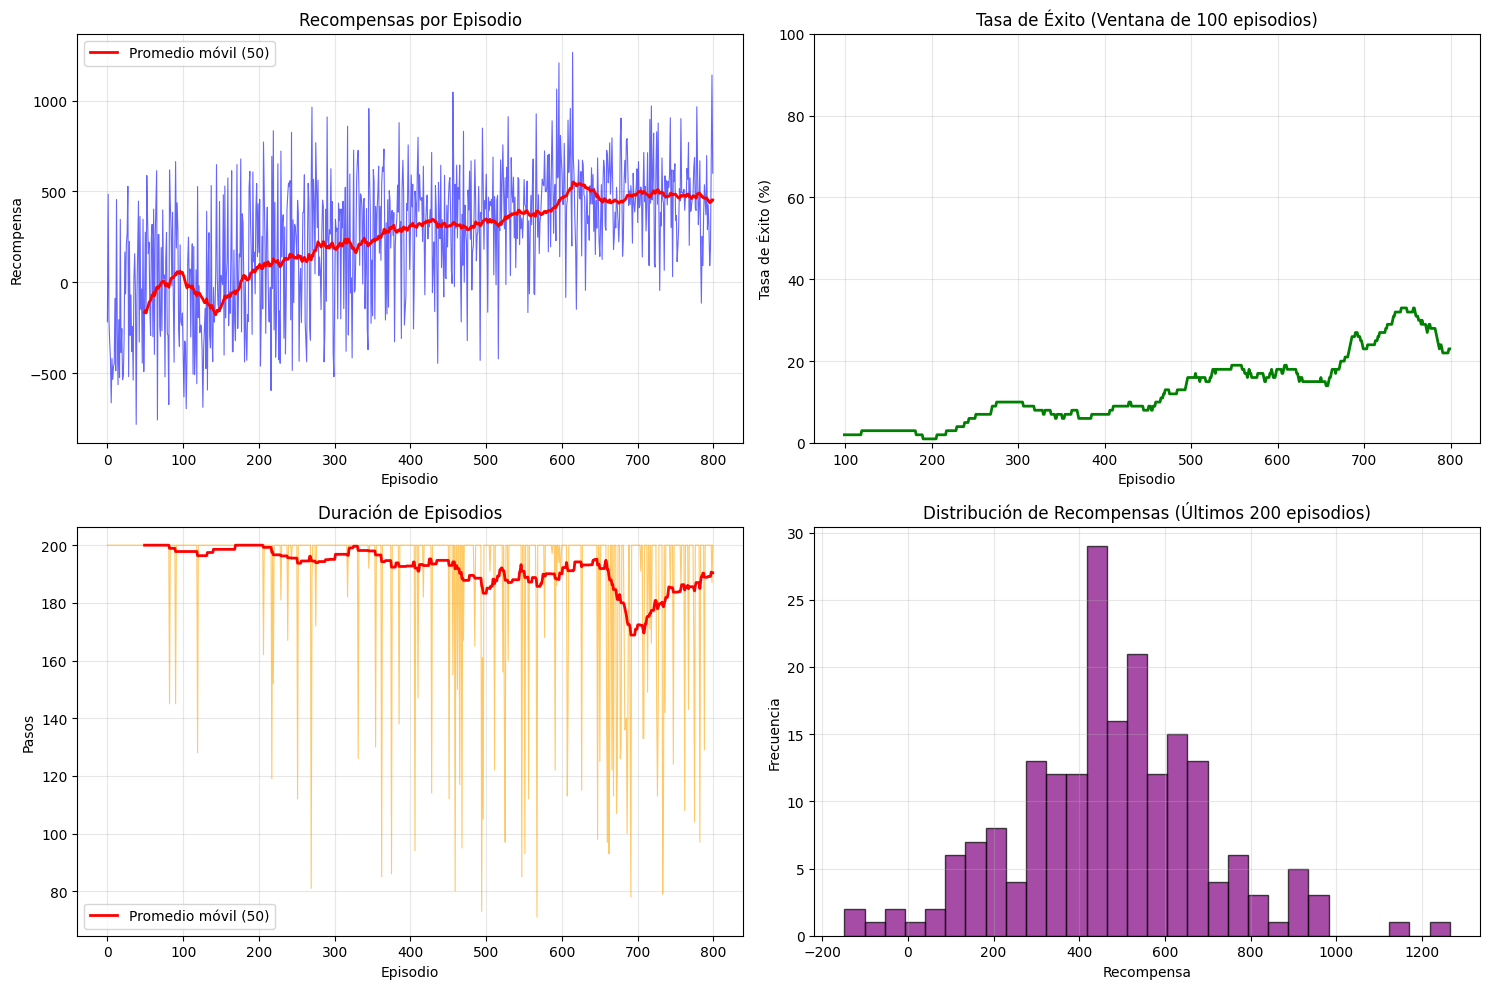

ESTADÍSTICAS FINALES DEL ENTRENAMIENTO
Episodios totales: 800
Recompensa promedio: 254.53
Mejor recompensa: 1264.58
Éxitos totales: 100
Tasa de éxito general: 12.5%
Tasa de éxito (últimos 100 episodios): 23.0%


In [43]:
# Ejecutar el entrenamiento
print("Iniciando entrenamiento del brazo robótico...")
print("Configuración:")
print("- Algoritmo: PPO (Proximal Policy Optimization)")
print("- Espacio de trabajo: 1 metro")
print("- Articulaciones: 3 (6 DOF)")
print("- Acciones: 7 (6 movimientos + 1 voltear)")
print("=" * 50)

resultados = entrenar_agente(episodios=800, verbose=True)

# Mostrar resultados
graficar_resultados(resultados)


EVALUACIÓN FINAL DEL AGENTE
Evaluando agente entrenado...
----------------------------------------
Episodio 1: ✗ Fallo | Recompensa: 575.4 | Pasos: 200
Episodio 2: ✗ Fallo | Recompensa: 348.4 | Pasos: 200
Episodio 3: ✗ Fallo | Recompensa: 506.4 | Pasos: 200
Episodio 4: ✗ Fallo | Recompensa: 458.3 | Pasos: 200
Episodio 5: ✗ Fallo | Recompensa: 310.8 | Pasos: 200
----------------------------------------
RESULTADOS DE EVALUACIÓN:
Tasa de éxito: 22.0% (11/50)
Recompensa promedio: 567.39 ± 193.73
Pasos promedio: 183.1 ± 33.0
----------------------------------------

Visualizando comportamiento del agente entrenado...


<Figure size 1200x800 with 0 Axes>

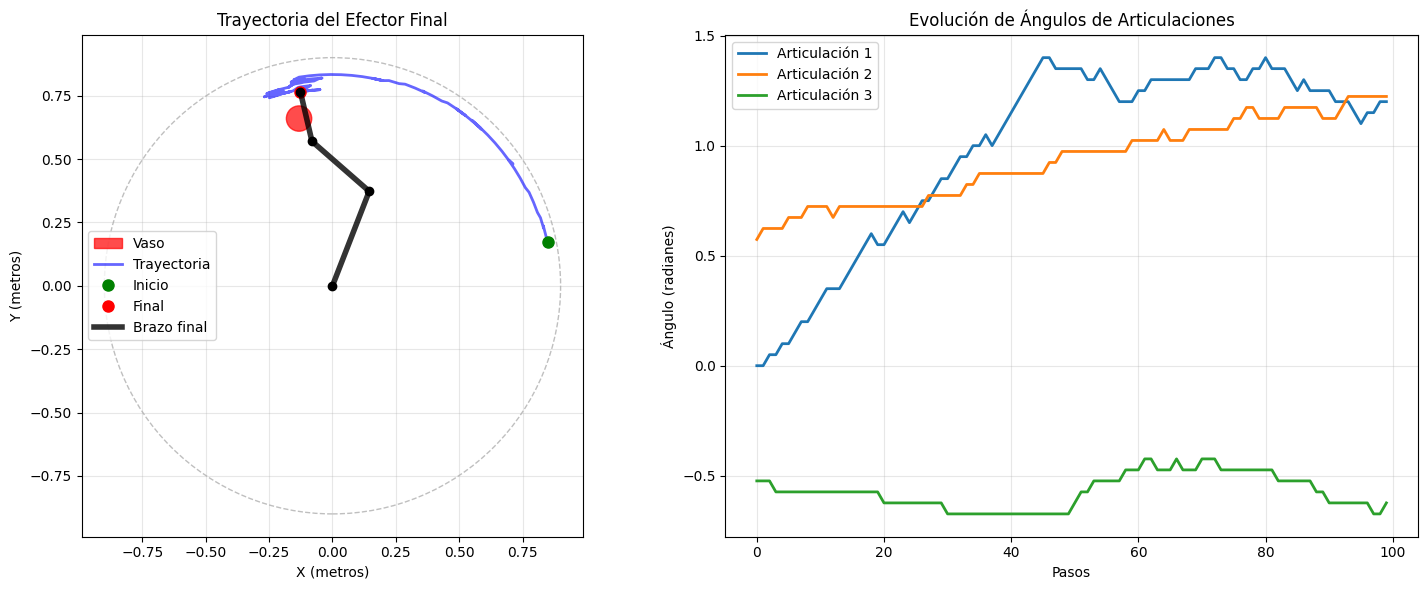

Simulación completada en 100 pasos
✗ No se completó la tarea. Distancia final al vaso: 0.105m


In [44]:
# Evaluar el agente entrenado
print("\n" + "=" * 50)
print("EVALUACIÓN FINAL DEL AGENTE")
print("=" * 50)

agente_entrenado = resultados['agente']
env_eval = resultados['env']

# Evaluación cuantitativa
resultados_eval = evaluar_agente(agente_entrenado, env_eval, n_evaluaciones=50)

# Visualización del comportamiento
print("\nVisualizando comportamiento del agente entrenado...")
visualizar_brazo(env_eval, agente_entrenado, n_pasos=100)

In [47]:
def analizar_rendimiento(resultados, resultados_eval):
    """Análisis detallado del rendimiento del agente"""
    print("\n" + "=" * 60)
    print("ANÁLISIS DETALLADO DE RENDIMIENTO")
    print("=" * 60)

    recompensas = resultados['recompensas']
    exitos = resultados['exitos']

    # Análisis temporal del aprendizaje
    print("\n1. PROGRESO DE APRENDIZAJE:")
    print("-" * 30)

    # Dividir en fases
    n_episodios = len(recompensas)
    fase1 = n_episodios // 3
    fase2 = 2 * n_episodios // 3

    # Fase inicial (exploración)
    recompensa_fase1 = np.mean(recompensas[:fase1])
    exito_fase1 = sum(exitos[:fase1]) / fase1 * 100

    # Fase intermedia (aprendizaje)
    recompensa_fase2 = np.mean(recompensas[fase1:fase2])
    exito_fase2 = sum(exitos[fase1:fase2]) / (fase2 - fase1) * 100

    # Fase final (refinamiento)
    recompensa_fase3 = np.mean(recompensas[fase2:])
    exito_fase3 = sum(exitos[fase2:]) / (n_episodios - fase2) * 100

    print(f"Fase 1 (Exploración): Recompensa={recompensa_fase1:.1f}, Éxito={exito_fase1:.1f}%")
    print(f"Fase 2 (Aprendizaje): Recompensa={recompensa_fase2:.1f}, Éxito={exito_fase2:.1f}%")
    print(f"Fase 3 (Refinamiento): Recompensa={recompensa_fase3:.1f}, Éxito={exito_fase3:.1f}%")

    # Mejora relativa
    mejora_recompensa = ((recompensa_fase3 - recompensa_fase1) / abs(recompensa_fase1)) * 100
    mejora_exito = exito_fase3 - exito_fase1

    print(f"\nMejora en recompensa: {mejora_recompensa:.1f}%")
    print(f"Mejora en tasa de éxito: {mejora_exito:.1f} puntos porcentuales")

    # Análisis de estabilidad
    print("\n2. ESTABILIDAD DEL APRENDIZAJE:")
    print("-" * 30)

    # Variabilidad en las últimas 100 evaluaciones
    ultimas_recompensas = recompensas[-100:]
    variabilidad = np.std(ultimas_recompensas)
    print(f"Desviación estándar (últimos 100 episodios): {variabilidad:.2f}")

    # Análisis de convergencia
    ventana = 50
    mejores_50 = np.max([np.mean(recompensas[i:i+ventana])
                         for i in range(len(recompensas)-ventana)])
    convergencia = (np.mean(ultimas_recompensas) / mejores_50) * 100
    print(f"Índice de convergencia: {convergencia:.1f}%")

    # Evaluación final
    print("\n3. EVALUACIÓN FINAL:")
    print("-" * 30)
    print(f"Tasa de éxito en evaluación: {resultados_eval['tasa_exito']:.1f}%")
    print(f"Recompensa promedio en evaluación: {np.mean(resultados_eval['recompensas']):.2f}")

    # Clasificación del rendimiento
    if resultados_eval['tasa_exito'] >= 80:
        rendimiento = "EXCELENTE"
    elif resultados_eval['tasa_exito'] >= 60:
        rendimiento = "BUENO"
    elif resultados_eval['tasa_exito'] >= 40:
        rendimiento = "REGULAR"
    else:
        rendimiento = "NECESITA MEJORA"

    print(f"\nCLASIFICACIÓN DEL RENDIMIENTO: {rendimiento}")

    # Recomendaciones
    print("\n4. RECOMENDACIONES PARA MEJORA:")
    print("-" * 30)

    if resultados_eval['tasa_exito'] < 70:
        print("- Incrementar episodios de entrenamiento")
        print("- Ajustar hiperparámetros (learning rate, epsilon decay)")
        print("- Considerar recompensas más densas")

    if variabilidad > 20:
        print("- Implementar técnicas de regularización")
        print("- Aumentar el batch size para estabilidad")

    if convergencia < 90:
        print("- Implementar early stopping")
        print("- Usar learning rate scheduling")

# Ejecutar análisis completo
analizar_rendimiento(resultados, resultados_eval)




ANÁLISIS DETALLADO DE RENDIMIENTO

1. PROGRESO DE APRENDIZAJE:
------------------------------
Fase 1 (Exploración): Recompensa=-0.6, Éxito=3.8%
Fase 2 (Aprendizaje): Recompensa=297.9, Éxito=12.0%
Fase 3 (Refinamiento): Recompensa=465.3, Éxito=21.7%

Mejora en recompensa: 82921.4%
Mejora en tasa de éxito: 18.0 puntos porcentuales

2. ESTABILIDAD DEL APRENDIZAJE:
------------------------------
Desviación estándar (últimos 100 episodios): 230.55
Índice de convergencia: 84.8%

3. EVALUACIÓN FINAL:
------------------------------
Tasa de éxito en evaluación: 22.0%
Recompensa promedio en evaluación: 567.39

CLASIFICACIÓN DEL RENDIMIENTO: NECESITA MEJORA

4. RECOMENDACIONES PARA MEJORA:
------------------------------
- Incrementar episodios de entrenamiento
- Ajustar hiperparámetros (learning rate, epsilon decay)
- Considerar recompensas más densas
- Implementar técnicas de regularización
- Aumentar el batch size para estabilidad
- Implementar early stopping
- Usar learning rate scheduling
